In [56]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

df = pd.read_csv("../serving/output_data/predictions.csv")
df.head()

,event_time,machine_id,temperature,vibration,rpm,hour,minute,second,is_hot_pred,hot_probability
0,2025-06-20 19:31:43.041320,M-001,63.06,0.063,1725,19,31,43,0,0.017498
1,2025-06-20 19:31:43.082343,M-002,77.72,0.233,2018,19,31,43,0,0.023436
2,2025-06-20 19:31:43.125830,M-002,60.48,0.201,1693,19,31,43,0,0.023436
3,2025-06-20 19:31:43.162174,M-004,77.05,0.089,2092,19,31,43,0,0.001749
4,2025-06-20 19:31:43.193086,M-001,80.47,0.092,2038,19,31,43,0,0.001749


In [57]:
print("Overall hot rate:", df["is_hot_pred"].mean())

print(df["hot_probability"].describe())

Overall hot rate: 0.17835671342685372
count    499.000000
mean       0.178172
std        0.344764
min        0.000000
25%        0.007085
50%        0.017903
75%        0.039616
max        0.978366
Name: hot_probability, dtype: float64


In [58]:
TH = 85
df["is_hot_true"] = (df["temperature"] > TH).astype(int)

cm = confusion_matrix(df["is_hot_true"], df["is_hot_pred"])
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[410   0]
 [  0  89]]


In [59]:
print(classification_report(df["is_hot_true"], df["is_hot_pred"].round(3)))
print("ROC AUC:", roc_auc_score(df["is_hot_true"], df["hot_probability"].round(3)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       1.00      1.00      1.00        89

    accuracy                           1.00       499
   macro avg       1.00      1.00      1.00       499
weighted avg       1.00      1.00      1.00       499

ROC AUC: 1.0


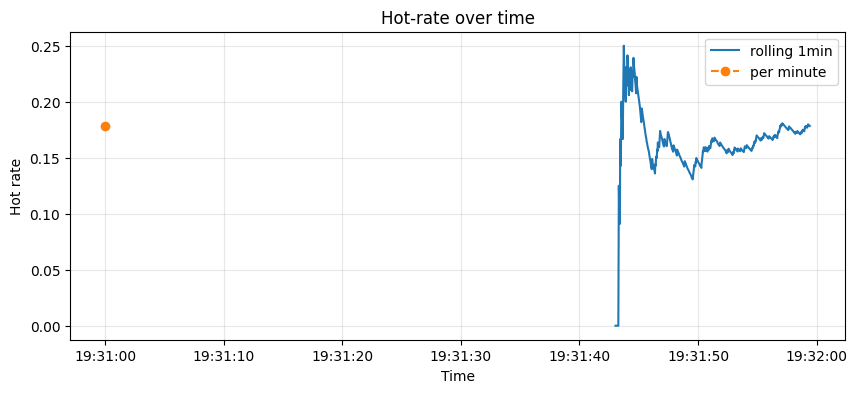

In [60]:
df["event_time"] = pd.to_datetime(df["event_time"])
df.set_index("event_time", inplace=True)

hot_rate = df["is_hot_pred"].rolling(window=pd.Timedelta("1min")).mean()
hot_rate_per_min = df["is_hot_pred"].resample("1min").mean()

plt.figure(figsize=(10,4))
plt.plot(hot_rate.index,     hot_rate.values,     label="rolling 1min")
plt.plot(hot_rate_per_min.index, hot_rate_per_min.values, marker="o", linestyle="--", label="per minute")
plt.legend()
plt.title("Hot-rate over time")
plt.ylabel("Hot rate")
plt.xlabel("Time")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

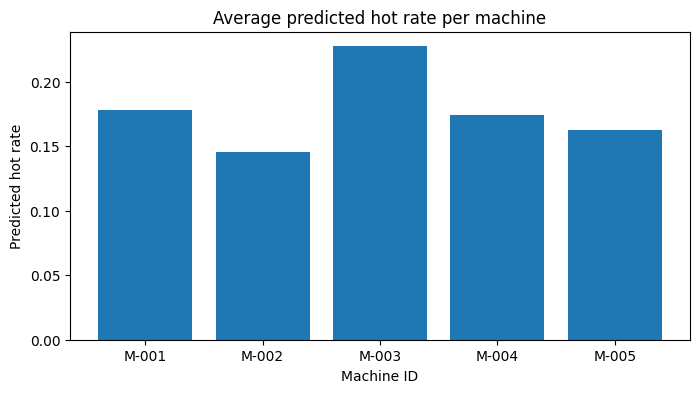

In [61]:
group = df.groupby("machine_id").agg({
      "is_hot_pred":"mean",
      "hot_probability":"mean",
      "temperature":"mean"
}).reset_index()

plt.figure(figsize=(8,4))
plt.bar(group["machine_id"], group["is_hot_pred"])
plt.title("Average predicted hot rate per machine")
plt.xlabel("Machine ID")
plt.ylabel("Predicted hot rate")
plt.show()

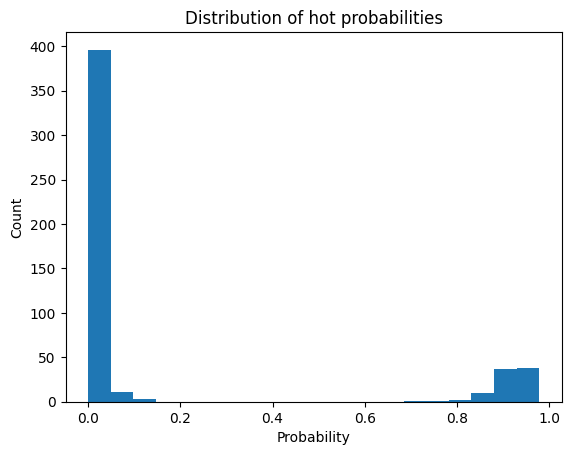

In [62]:
plt.figure()
plt.hist(df["hot_probability"], bins=20)
plt.title("Distribution of hot probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()